In [1]:
import sys
sys.path.append("..")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from reinforcetrader.dqn_agent import DRLAgent
from reinforcetrader.explain_agent import ModelExplainer

# DQN Architecture Analysis

In [2]:
# Set the keras model path below
MODEL_PATH = '../model_checkpoints/DDQN_DSRC_AE1.keras'
MODEL_REWARD_FUNCTION = 'DSR'
# Create explainer object (Load keras model)
explainer = ModelExplainer(MODEL_PATH, MODEL_REWARD_FUNCTION)

I0000 00:00:1766963176.089257  107336 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model successfully loaded from ../model_checkpoints/DDQN_DSRC_AE1.keras


In [3]:
# Get DQN summary (layer names, shapes, etc.)
explainer.get_model_summary()

Model: "DualBranchDQN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ state_input         │ (None, 60, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reward_input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 64)    │      2,560 │ state_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ reward_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 60, 32)    │      6,176 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 60, 32)    │      3,104 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ state_output        │ (None, 64)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reward_output       │ (None, 4)         │         68 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ late_fusion         │ (None, 68)        │          0 │ state_output[0][… │
│ (Concatenate)       │                   │            │ reward_output[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,416 │ late_fusion[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ advantage_value     │ (None, 3)         │         51 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Mean)         │ (None, 1)         │          0 │ advantage_value[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ state_value (Dense) │ (None, 1)         │         17 │ dense_4[0][0]   

 Total params: 60,554 (236.54 KB)

 Trainable params: 20,184 (78.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,370 (157.70 KB)

## Grad-CAM Method
We first employ the Grad-CAM method, as our setup can be treated as a classification task where the action with the highest $Q$-value is chosen. Given our CNN architecture, we can readily implement Grad-CAM on the last convolutional layer of the feature state representation branch. However, this method has limitations; notably, it cannot provide a detailed explanation for the predicted class, as it only highlights regions of high importance. Furthermore, visual representations can be severely misleading, which is why we subsequently explore the SHAP method.

In [4]:
# Set the ticker and buy date to explore
SCENARIO_TICKER = 'MCD'
BUY_DATE = pd.to_datetime('2021-01-12')

def load_state_reward(idf1, idf2: str) -> tuple[np.ndarray, np.ndarray]:
    f_path = lambda n: f'../data/test/states/{idf1}_{idf2}_{n}.npy'
    states = np.load(f_path('states'))
    rewards = np.load(f_path('rewards'))
    return states, rewards

# Load the saved state/reward representations for MCD from buy to sell
trade_states, trade_rewards = load_state_reward(SCENARIO_TICKER, BUY_DATE.strftime("%Y_%m_%d"))
# Load 200 random samples from the backtesting
rand_states, rand_rewards = load_state_reward('rand', '800')

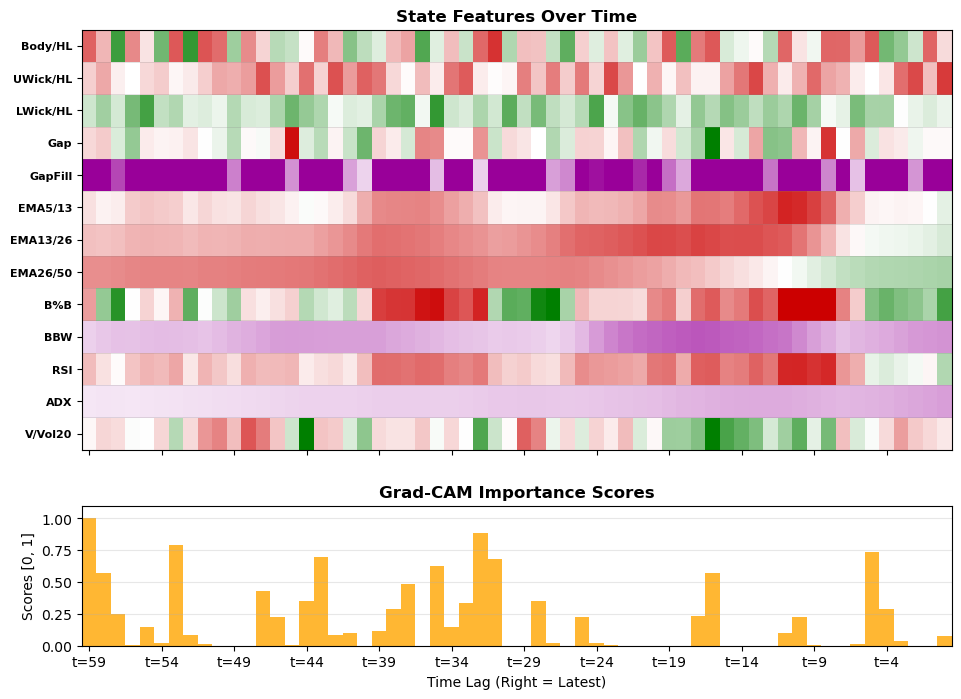

In [5]:
# Choose the last layer for grad-CAM
LAYER_NAME = 'conv1d_2'

# Run the grad-CAM on last 1d conv layer in the CNN branch for buy state
explainer.run_grad_cam(trade_states[0], trade_rewards[0], action=DRLAgent.A_BUY, layer_name=LAYER_NAME)

## SHAP Method
We utilize the Gradient SHAP method, which combines ideas from SHAP, DeepLIFT, and Integrated Gradients. Unlike Grad-CAM, which is restricted to the convolutional layers of the CNN branch, Gradient SHAP allows us to attribute importance to all input features simultaneously. This enables us to quantify the marginal contribution of features from both the State Window (CNN branch) and the Reward Parameters (MLP branch) towards the final Q-value prediction, offering a comprehensive view of the agent's decision-making process.

Note: Gradient SHAP estimates feature importance relative to a provided background dataset (baseline). Therefore, the resulting values explain how a specific observation deviates from the "average" environment conditions represented by that baseline.

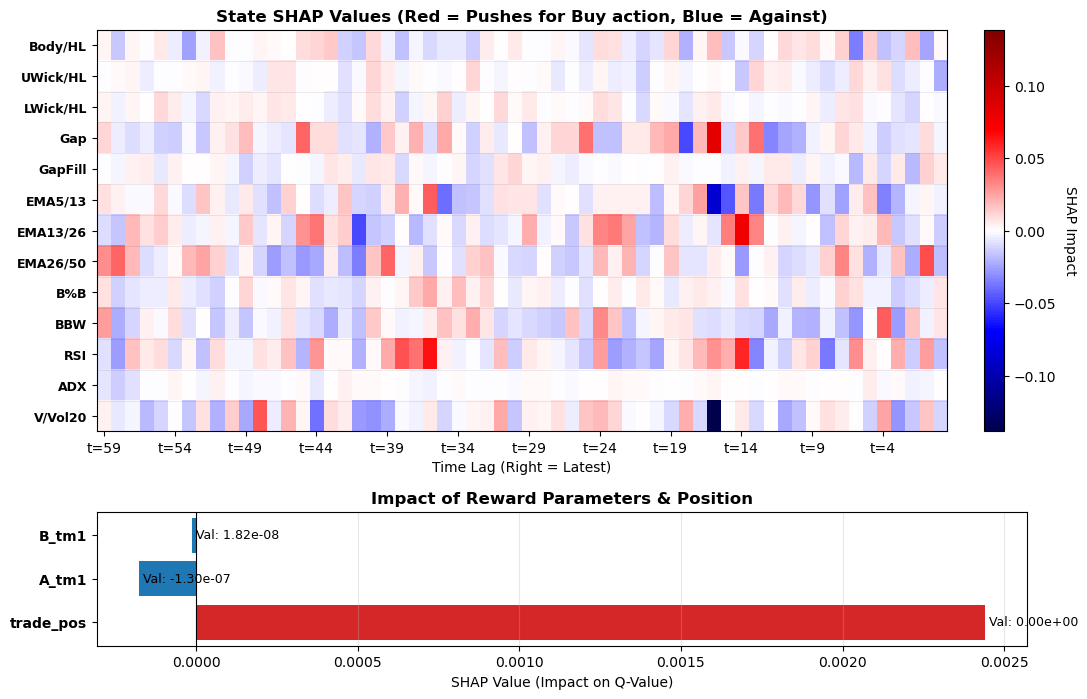

In [6]:
# First, setup SHAP explainer with background data (to compute the 'baseline')
explainer.setup_shap_explainer(rand_states, rand_rewards)

# Run SHAP method for specific ticker/agent state and action
explainer.run_shap(trade_states[0], trade_rewards[0], action=DRLAgent.A_BUY)